# Examine parameters of circuits in the form of binding energies

Here we look at the statistics underlying the parameters of a dataset of randomly generated circuits. We have generated roughly 1 million circuits and calculated their interaction parameters by simulating their binding energies. In this case, all nodes in the circuit are RNAs, so an RNA interaction simulator (IntaRNA) was used to estimate the minimum free energy of binding between all species within a circuit. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import sklearn.preprocessing as pre


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from synbio_morpher.srv.parameter_prediction.interactions import INTERACTION_TYPES
from synbio_morpher.srv.io.loaders.experiment_loading import INTERACTION_FILE_ADDONS
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.misc.string_handling import prettify_keys_for_label


In [2]:
fn = '../data/gather_interaction_stats/2023_07_15_220412/circuit_stats.csv'
data = pd.read_csv(fn)

While the interaction calculated by the RNA simulator is in units of energy (in kcal/mol and denoted as `energies`), we calculated the $K_{eq}$ equilibrium constants (denoted as `eqconstants`) and the binding rates of dissociation (denoted as `binding_rates_dissociation`) through a nonlinear mapping (detailed in earlier explanation notebook). The interaction columns ending with `'_i-j'` indicate the pair of species that are interacting, so column `energies_0-0` refers to the minimum free binding energy between species 0 and itself.

In [3]:
data.columns

Index(['name', 'interacting', 'self_interacting', 'num_interacting',
       'num_self_interacting', 'binding_sites_0-0', 'binding_sites_0-1',
       'binding_sites_0-2', 'binding_sites_1-0', 'binding_sites_1-1',
       'binding_sites_1-2', 'binding_sites_2-0', 'binding_sites_2-1',
       'binding_sites_2-2', 'binding_rates_dissociation_0-0',
       'binding_rates_dissociation_0-1', 'binding_rates_dissociation_0-2',
       'binding_rates_dissociation_1-0', 'binding_rates_dissociation_1-1',
       'binding_rates_dissociation_1-2', 'binding_rates_dissociation_2-0',
       'binding_rates_dissociation_2-1', 'binding_rates_dissociation_2-2',
       'energies_0-0', 'energies_0-1', 'energies_0-2', 'energies_1-0',
       'energies_1-1', 'energies_1-2', 'energies_2-0', 'energies_2-1',
       'energies_2-2', 'eqconstants_0-0', 'eqconstants_0-1', 'eqconstants_0-2',
       'eqconstants_1-0', 'eqconstants_1-1', 'eqconstants_1-2',
       'eqconstants_2-0', 'eqconstants_2-1', 'eqconstants_2-2',
      

We expand these per-species columns into a pooled column for each interaction type.

In [4]:
datam = data.melt(['name'], value_vars=get_true_interaction_cols(data, INTERACTION_TYPES[0]), var_name='idx', value_name=INTERACTION_TYPES[0])
for i in INTERACTION_TYPES[1:]:
    dfm = data.melt(['name'], value_vars=get_true_interaction_cols(data, i), var_name='_', value_name=i)
    datam[i] = dfm[i]

Text(0.5, 0.98, '$10^5$ Randomly generated circuits')

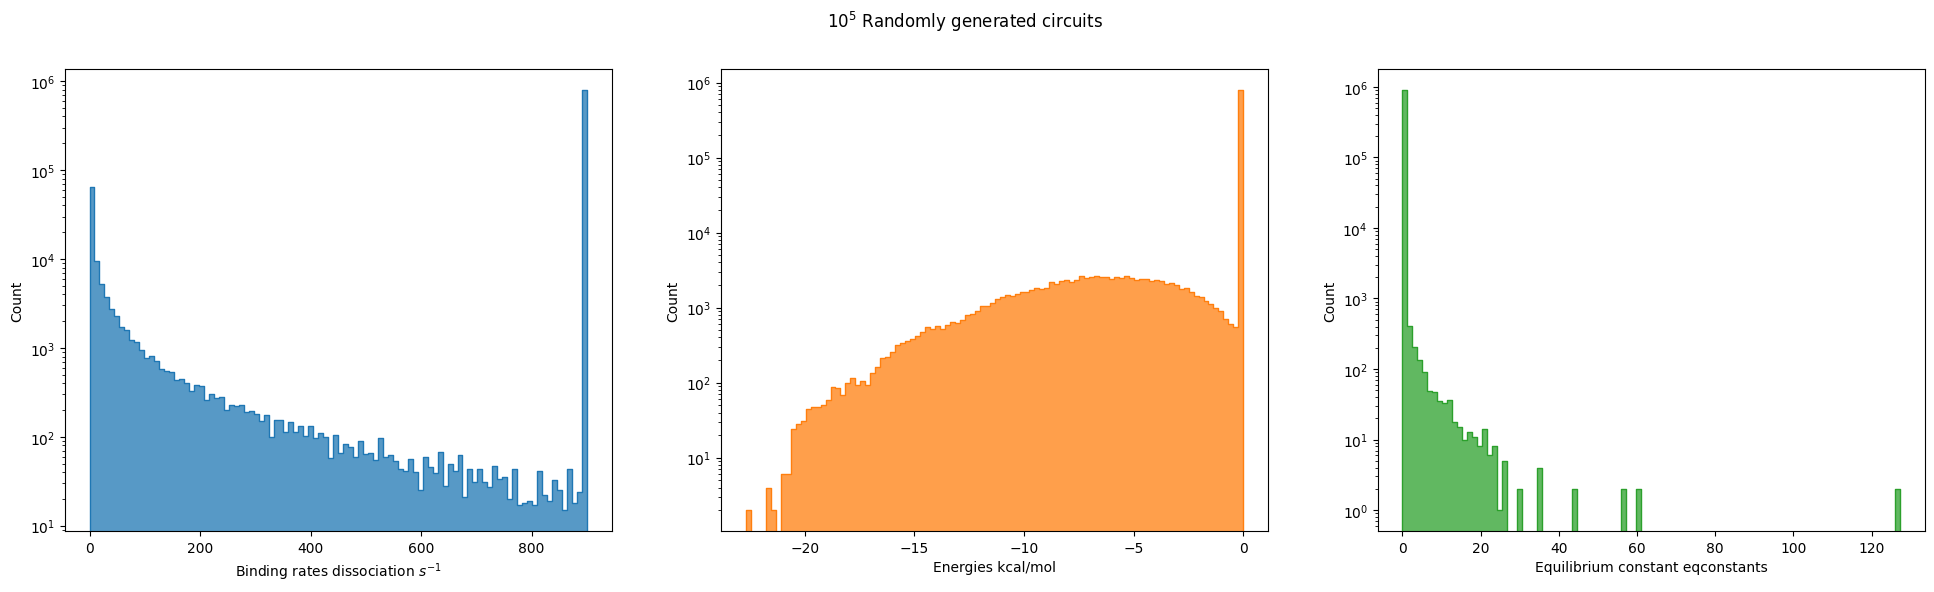

In [10]:
plt.figure(figsize=(8*len(INTERACTION_TYPES), 6))
palette = sns.color_palette()
for ii, i in enumerate(INTERACTION_TYPES):
    ax = plt.subplot(1, len(INTERACTION_TYPES), ii+1)
    sns.histplot(datam, x=i, element='step', log_scale=[False, True], color=sns.color_palette()[ii], bins=100)
    plt.xlabel(prettify_keys_for_label(i) + f' {INTERACTION_FILE_ADDONS[i]}')
plt.suptitle(f'$10^{int(np.log10(len(data)))}$ Randomly generated circuits')

## Draw equal parts of different segments of each distribution

In [6]:
def uniform_sampling(data, n_samples):
    """
    'GC'
    Samples from the dataset equally as if the distribution was uniform.

    Parameters:
    data (array-like): Input data with a heavy-tailed, non-uniform distribution.
    n_samples (int): Number of samples to generate.

    Returns:
    array: Samples from the input data with a uniform distribution.
    """
    # Calculate the PDF of the input data
    if sum(data) == 0:
        pdf = data
    else:
        pdf = data / np.sum(data)

    # Calculate the CDF of the input data
    cdf = np.cumsum(pdf)

    # Generate n_samples from a uniform distribution
    u = np.random.uniform(size=n_samples)

    # Apply the inverse CDF to obtain samples from the non-uniform distribution
    samples = np.interp(u, cdf, np.arange(len(data)))

    return samples.astype(int)


(array([  9.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          5.,  13.,   0.,   0.,   0.,   4.,   0.,   0.,   2.,   5.,   0.,
          4.,   0.,   8.,   9.,  20.,  24.,  25.,  26.,  24.,  31.,  11.,
         42.,  31.,  56.,  40.,  54.,  22.,  29.,  62.,  49.,  49.,  31.,
         34.,  50.,  38.,  66.,  79.,  42., 123.,  59.,  71.,  35.,  53.,
         60.,  54.,  85.,  73.,  96., 133.,  76.,  83.,  77.,  66.,  98.,
         70.,  68.,  50.,  76.]),
 array([-22.68 , -22.599, -22.518, -22.437, -22.356, -22.275, -22.194,
        -22.113, -22.032, -21.951, -21.87 , -21.789, -21.708, -21.627,
        -21.546, -21.465, -21.384, -21.303, -21.222, -21.141, -21.06 ,
        -20.979, -20.898, -20.817, -20.736, -20.655, -20.574, -20.493,
        -20.412, -20.331, -20.25 , -20.169, -20.088, -20.007, -19.926,
        -19.845, -19.764, -19.683, -19.602, -19.521, -19.44 , -19.359,
        -19.278, -19.197, -19.116, -19.035, -18.954, -18.873, -18.792,
        -18.711, -18.63 ,

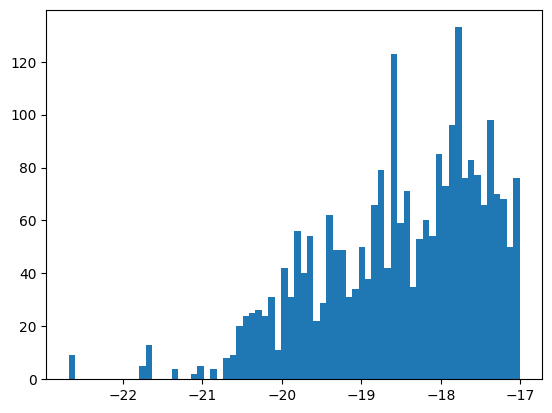

In [7]:
def fold_sampling(d, n_folds, n_samples):
    fold_size = int(len(d) / n_folds)
    sampled_data = np.array([])
    for f in range(int(n_folds)):
        curr_data = d.sort_values(ascending=True).values[f*fold_size:(f+1)*fold_size]
        samples = uniform_sampling(curr_data, int(n_samples/n_folds))
        sampled_data = np.concatenate([sampled_data, curr_data[samples]])
    return sampled_data

d = datam['energies']
n_folds=4
n_samples=10000
fold_size = int(len(d) / n_folds)
sampled_data = np.array([])
drange = (d.min(), d.max())
lim = d.max() - d.min()
for fi in np.linspace(d.min(), d.max(), n_folds):
    ff = fi + (lim / n_folds)
    curr_data = d[(d >= fi) & (d <= ff)].sort_values(ascending=True)
    samples = uniform_sampling(curr_data, int(n_samples/n_folds))
    sampled_data = np.concatenate([sampled_data, curr_data.iloc[samples]])
    break

# x = fold_sampling(datam['energies'], n_folds=10, n_samples=1000)
plt.hist(sampled_data, bins=70)

In [8]:
np.max(samples)

1093

<AxesSubplot: xlabel='energies', ylabel='Count'>

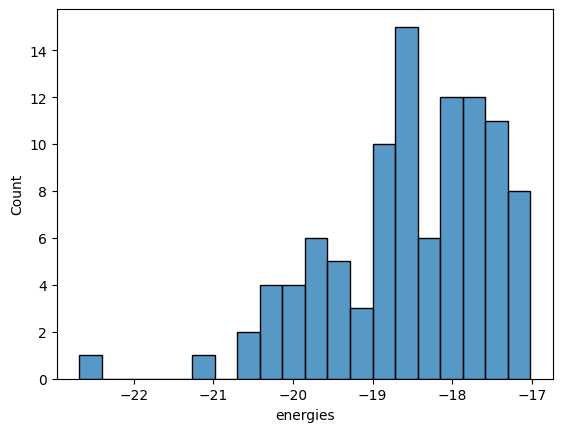

In [9]:
pdf = curr_data / np.sum(curr_data)

cdf = np.cumsum(np.abs(pdf))

u = np.random.uniform(size=100)

# Apply the inverse CDF to obtain samples from the non-uniform distribution
x_norm = pre.MinMaxScaler().fit_transform(pdf.values.reshape(-1, 1)).reshape(len(pdf))
samples = np.interp(u, cdf, np.arange(len(curr_data))).astype(int)
# sns.histplot(x=samples, bins=200)
sns.histplot(x=curr_data.iloc[samples], bins=20)
# sns.histplot(x=cdf, bins=20)